In [21]:
# !pip install pandas matplotlib seaborn fasttext wordcloud
from utils import *
from conn_mongo import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [22]:
cursor = collection.find()
raw_df = pd.DataFrame(cursor)

In [23]:
df = raw_df.copy()

In [24]:
list_col = list(df.columns)[2:]
print(list_col)

['name', 'location', 'description', 'jobExperience', 'privilege', 'field']


In [25]:
# lay cac cot dua vao trong danh sach
clean_cols(df, list_col)

In [26]:


# Gộp text từ nhiều cột để phân tích NLP
def combine_text(row):
    return " ".join([
        str(row.get('name', '')),
        str(row.get('description', '')),
        str(row.get('jobExperience', '')),
        str(row.get('privilege', ''))
    ])

df["all_text"] = df.apply(combine_text, axis=1)

# Áp dụng các hàm
df["exp_years"]   = df["all_text"].apply(extract_experience)
df["salary_usd"]  = df["all_text"].apply(extract_salary)
df["skills"]      = df["all_text"].apply(extract_skills)
df["level"]       = df["all_text"].apply(infer_level)
df["lang_req"]    = df["all_text"].apply(detect_language_required)

In [27]:
salary = df[df['salary_usd'] > 150]

In [28]:
salary_field = salary[['field', 'salary_usd']]

In [29]:
salary_by_field = salary_field.groupby(by='field').agg(func='mean')
salary_by_field

,salary_usd
field,
"ai, blockchain và dịch vụ deep tech",2080.000000
bán lẻ và bán buôn,720.000000
bất động sản và xây dựng,240.000000
chăm sóc sức khỏe,800.000000
công nghiệp tiện ích,6000.000000
dịch vụ tài chính,3660.000000
dịch vụ và tư vấn it,1880.851064
giáo dục và đào tạo,800.000000
ngân hàng,3500.000000


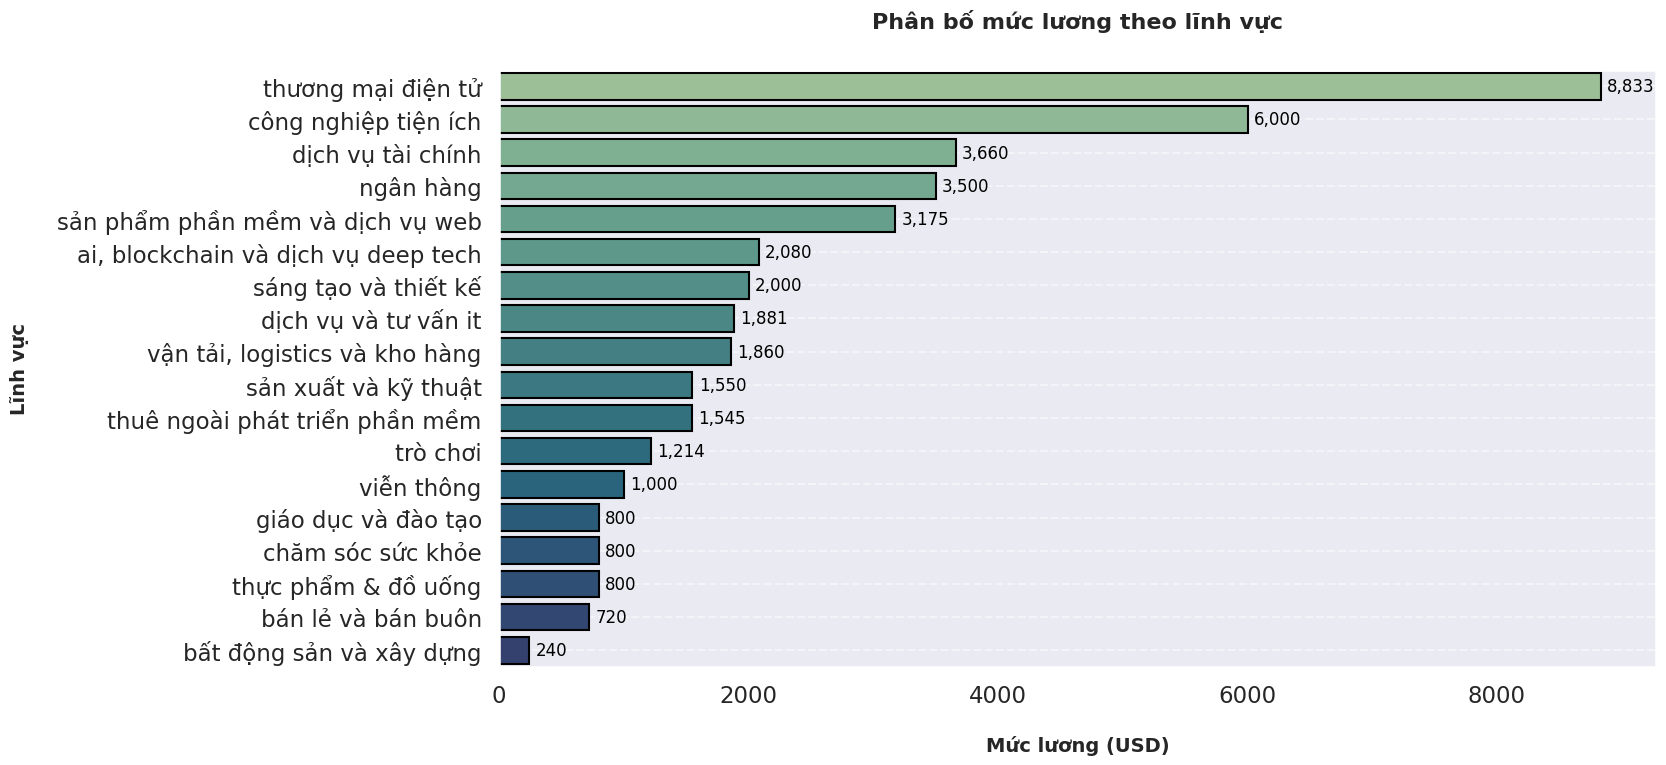

In [30]:
# Sắp xếp dữ liệu theo lương
salary_sorted = salary_by_field.sort_values(by='salary_usd', ascending=False).reset_index()

# Vẽ biểu đồ bằng Seaborn
plt.figure(figsize=(17, 8))
sns.set_style("dark")
sns.set_context("talk")

ax = sns.barplot(
    data=salary_sorted,
    y='field',
    x='salary_usd',
    palette='crest',
    edgecolor='black'
)

# Tùy chỉnh nhãn và tiêu đề
plt.xlabel('Mức lương (USD)', fontsize=14, labelpad=20, weight='bold')
plt.ylabel('Lĩnh vực', fontsize=14, labelpad=20, weight='bold')
plt.title('Phân bố mức lương theo lĩnh vực', fontsize=16, weight='bold', pad=30)

# Thêm số ở đầu mỗi cột
for i, v in enumerate(salary_sorted['salary_usd']):
    ax.text(
        v + 50,  # đẩy số ra bên phải một chút
        i,        # vị trí theo trục Y
        f'{v:,.0f}',  # định dạng số có dấu phẩy
        color='black',
        va='center',
        fontsize=12
    )
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [31]:
salary_lang = salary[['lang_req', 'salary_usd']]
salary_lang = salary_lang.groupby(by='lang_req').agg(func='mean')
salary_lang

,salary_usd
lang_req,
en,3597.142857
"en,ja",1630.000000
"en,ja,ko",4000.000000
"en,ko",1900.000000
ja,1488.571429
vi,1752.000000
zh,1200.000000


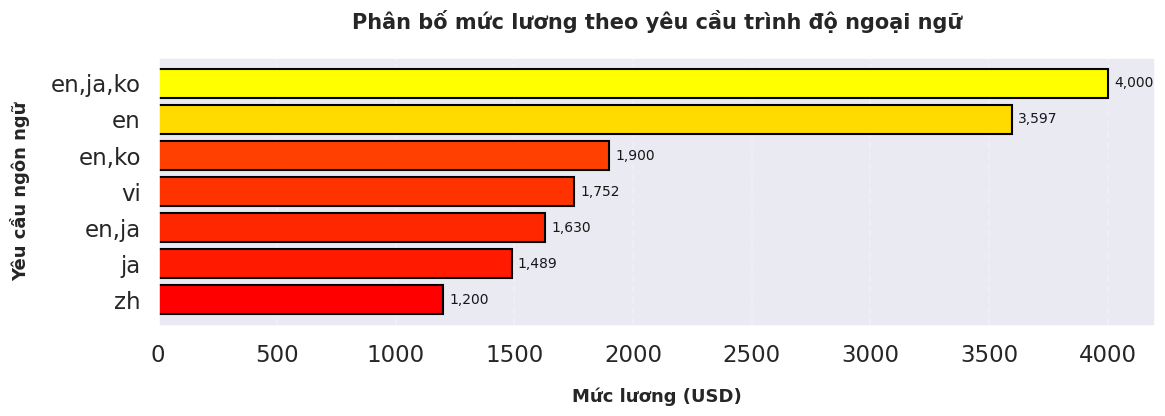

In [32]:
# Sắp xếp dữ liệu tăng dần
salary_sorted = salary_lang.sort_values(by='salary_usd')

cmap1 = cm.get_cmap('Blues')
cmap2 = cm.get_cmap('Pastel1')
norm = plt.Normalize(salary_sorted['salary_usd'].min(), salary_sorted['salary_usd'].max())  #type: ignore 
colors = cm.get_cmap('autumn')(norm(salary_sorted['salary_usd']))

# Vẽ biểu đồ ngang
fig, ax = plt.subplots(figsize=(12, 4.5))
bars = ax.barh(
    salary_sorted.index,
    salary_sorted['salary_usd'],
    color = colors,
    edgecolor='black'
)

# Thêm số ở cuối mỗi thanh
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 25,  # đẩy số ra bên phải
        bar.get_y() + bar.get_height() / 2,
        f'{width:,.0f}',
        va='center',
        fontsize=10,
        color='black',
        alpha=0.9
    )

# Tùy chỉnh nhãn và tiêu đề
ax.set_xlabel('Mức lương (USD)', fontsize=13, labelpad=15, weight='bold')
ax.set_ylabel('Yêu cầu ngôn ngữ', fontsize=13, labelpad=15, weight='bold')
ax.set_title('Phân bố mức lương theo yêu cầu trình độ ngoại ngữ', fontsize=15, weight='bold', pad=20)

# Tắt lưới hoặc làm mờ
ax.grid(axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()


In [33]:
salary['location_city'] = salary['location'].apply(lambda x: x.split(', ')[-1])
salary_by_city = salary[['location_city', 'salary_usd']].groupby(by='location_city').agg(func='mean')

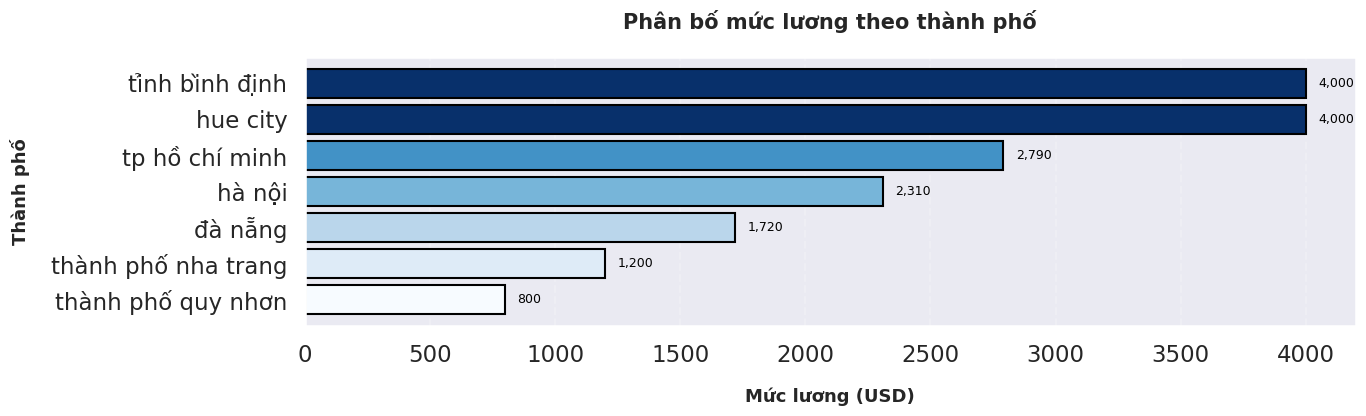

In [34]:
# Sắp xếp dữ liệu tăng dần (nếu cần)
salary_sorted = salary_by_city.sort_values(by='salary_usd')

# Tạo màu xanh dương đậm dần theo giá trị lương
norm = mcolors.Normalize(vmin=salary_sorted['salary_usd'].min(), vmax=salary_sorted['salary_usd'].max())
colors = cm.Blues(norm(salary_sorted['salary_usd'])) #type: ignore

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(14, 4.5))
bars = ax.barh(
    salary_sorted.index,
    salary_sorted['salary_usd'],
    color=colors,
    edgecolor='black'
)

# Thêm số ở cuối mỗi thanh
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 50,
        bar.get_y() + bar.get_height() / 2,
        f'{width:,.0f}',
        va='center',
        fontsize=9,
        color='black'
    )

# Tùy chỉnh nhãn và tiêu đề
ax.set_xlabel('Mức lương (USD)', fontsize=13, labelpad=15, weight='bold')
ax.set_ylabel('Thành phố', fontsize=13, labelpad=15, weight='bold')
ax.set_title('Phân bố mức lương theo thành phố', fontsize=15, weight='bold', pad=20)

# Lưới nhẹ
ax.grid(axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

In [35]:
df['location_city'] = df['location'].apply(lambda x: x.split(', ')[-1])

In [36]:
percent_job_city = df['location_city'].value_counts()

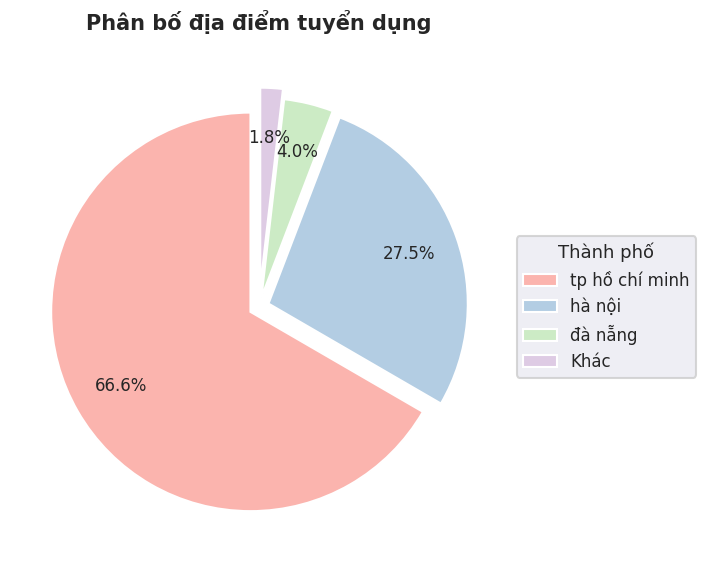

In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Lấy top 3 thành phố
top3 = percent_job_city.sort_values(ascending=False).head(3)
others = percent_job_city.drop(top3.index).sum()
pie_data = pd.concat([top3, pd.Series({'Khác': others})])

labels = pie_data.index
colors = cm.Pastel1.colors[:len(pie_data)] #type: ignore

# Tách riêng các lát nhỏ
explode = [
    0.05 if label in top3.index else
    0.08 if label == 'đà nẵng' else
    0.1 if label == 'Khác' else
    0.03
    for label in labels
]

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(9, 6))
wedges, texts, autotexts = ax.pie(  #type: ignore 
    pie_data,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=False,
    textprops={'fontsize': 12},
    pctdistance=0.75
)

# Thêm legend bên phải
ax.legend(
    wedges,
    labels,
    title="Thành phố",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=12,
    title_fontsize=13
)

# Tiêu đề
ax.set_title('Phân bố địa điểm tuyển dụng', fontsize=15, weight='bold', pad=20)

plt.tight_layout()
plt.show()


In [38]:
skill_list = df['skills']
flat_skill = [skill for sublist in skill_list.dropna() for skill in sublist]
flat_skill_series = pd.Series(flat_skill)
top_skill_demand = flat_skill_series.value_counts().head(30)

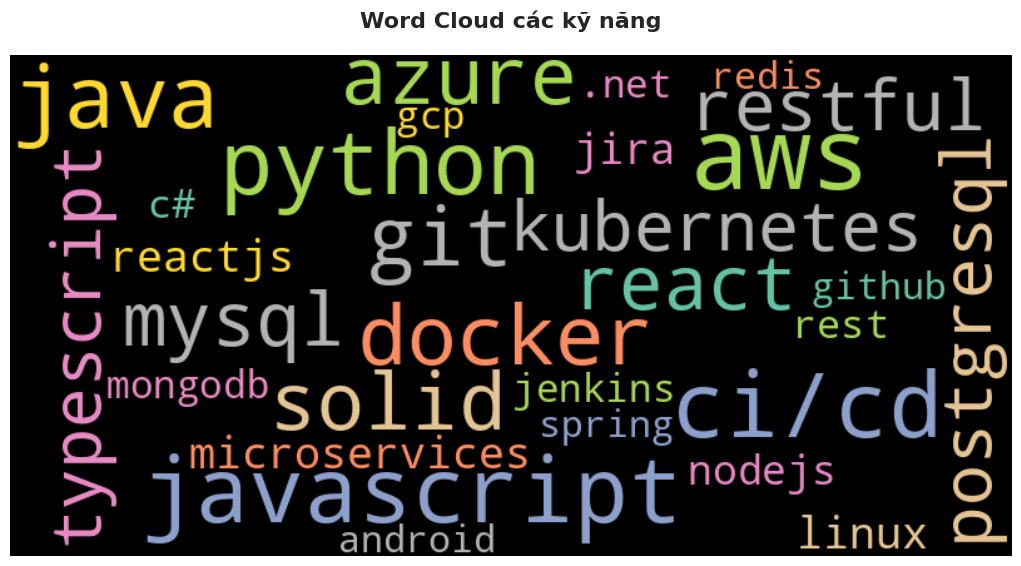

In [39]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Set2',  # màu pastel nhẹ
    max_words=200,
    max_font_size=80,
    prefer_horizontal=0.9,
    contour_color='gray',
    contour_width=2
).generate_from_frequencies(top_skill_demand)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud các kỹ năng', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()
